In [2]:
#Lets have matplotlib "inline"
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#Import packages we need
import os, sys, pyopencl
import numpy as np
from matplotlib import animation, rc
from matplotlib import pyplot as plt

#Finally, import our simulator
from SWESimulators import FBL, CTCS, DataOutput

#Set large figure sizes
rc('figure', figsize=(16.0, 12.0))
rc('animation', html='html5')

#Finally, import our simulator
from SWESimulators import CTCS2Layer, DataOutput, PlotHelper

In [3]:
#Make sure we get compiler output from OpenCL
os.environ["PYOPENCL_COMPILER_OUTPUT"] = "1"

#Set which CL device to use, and disable kernel caching
if (str.lower(sys.platform).startswith("linux")):
    os.environ["PYOPENCL_CTX"] = "0"
else:
    os.environ["PYOPENCL_CTX"] = "1"
os.environ["CUDA_CACHE_DISABLE"] = "1"
os.environ["PYOPENCL_COMPILER_OUTPUT"] = "1"
os.environ["PYOPENCL_NO_CACHE"] = "1"

#Create OpenCL context
cl_ctx = pyopencl.create_some_context()
print "Using ", cl_ctx.devices[0].name

Using  Intel(R) HD Graphics Skylake ULT GT2


Using  Intel(R) HD Graphics Skylake ULT GT2
i: 0 t: 0.0
i: 1 t: 10.0
i: 2 t: 20.0
i: 3 t: 30.0
i: 4 t: 40.0
i: 5 t: 50.0
i: 6 t: 60.0
i: 7 t: 70.0
i: 8 t: 80.0
i: 9 t: 90.0
i: 10 t: 100.0
i: 11 t: 110.0
i: 12 t: 120.0
i: 13 t: 130.0
i: 14 t: 140.0
i: 15 t: 150.0
i: 16 t: 160.0
i: 17 t: 170.0
i: 18 t: 180.0
i: 19 t: 190.0
i: 20 t: 200.0
i: 21 t: 210.0
i: 22 t: 220.0
i: 23 t: 230.0
i: 24 t: 240.0
i: 25 t: 250.0
i: 26 t: 260.0
i: 27 t: 270.0
i: 28 t: 280.0
i: 29 t: 290.0
i: 30 t: 300.0
i: 31 t: 310.0
i: 32 t: 320.0
i: 33 t: 330.0
i: 34 t: 340.0
i: 35 t: 350.0
i: 36 t: 360.0
i: 37 t: 370.0
i: 38 t: 380.0
i: 39 t: 390.0
i: 40 t: 400.0
i: 41 t: 410.0
i: 42 t: 420.0
i: 43 t: 430.0
i: 44 t: 440.0
i: 45 t: 450.0
i: 46 t: 460.0
i: 47 t: 470.0
i: 48 t: 480.0
i: 49 t: 490.0
Closing '2LayerTest.nc'


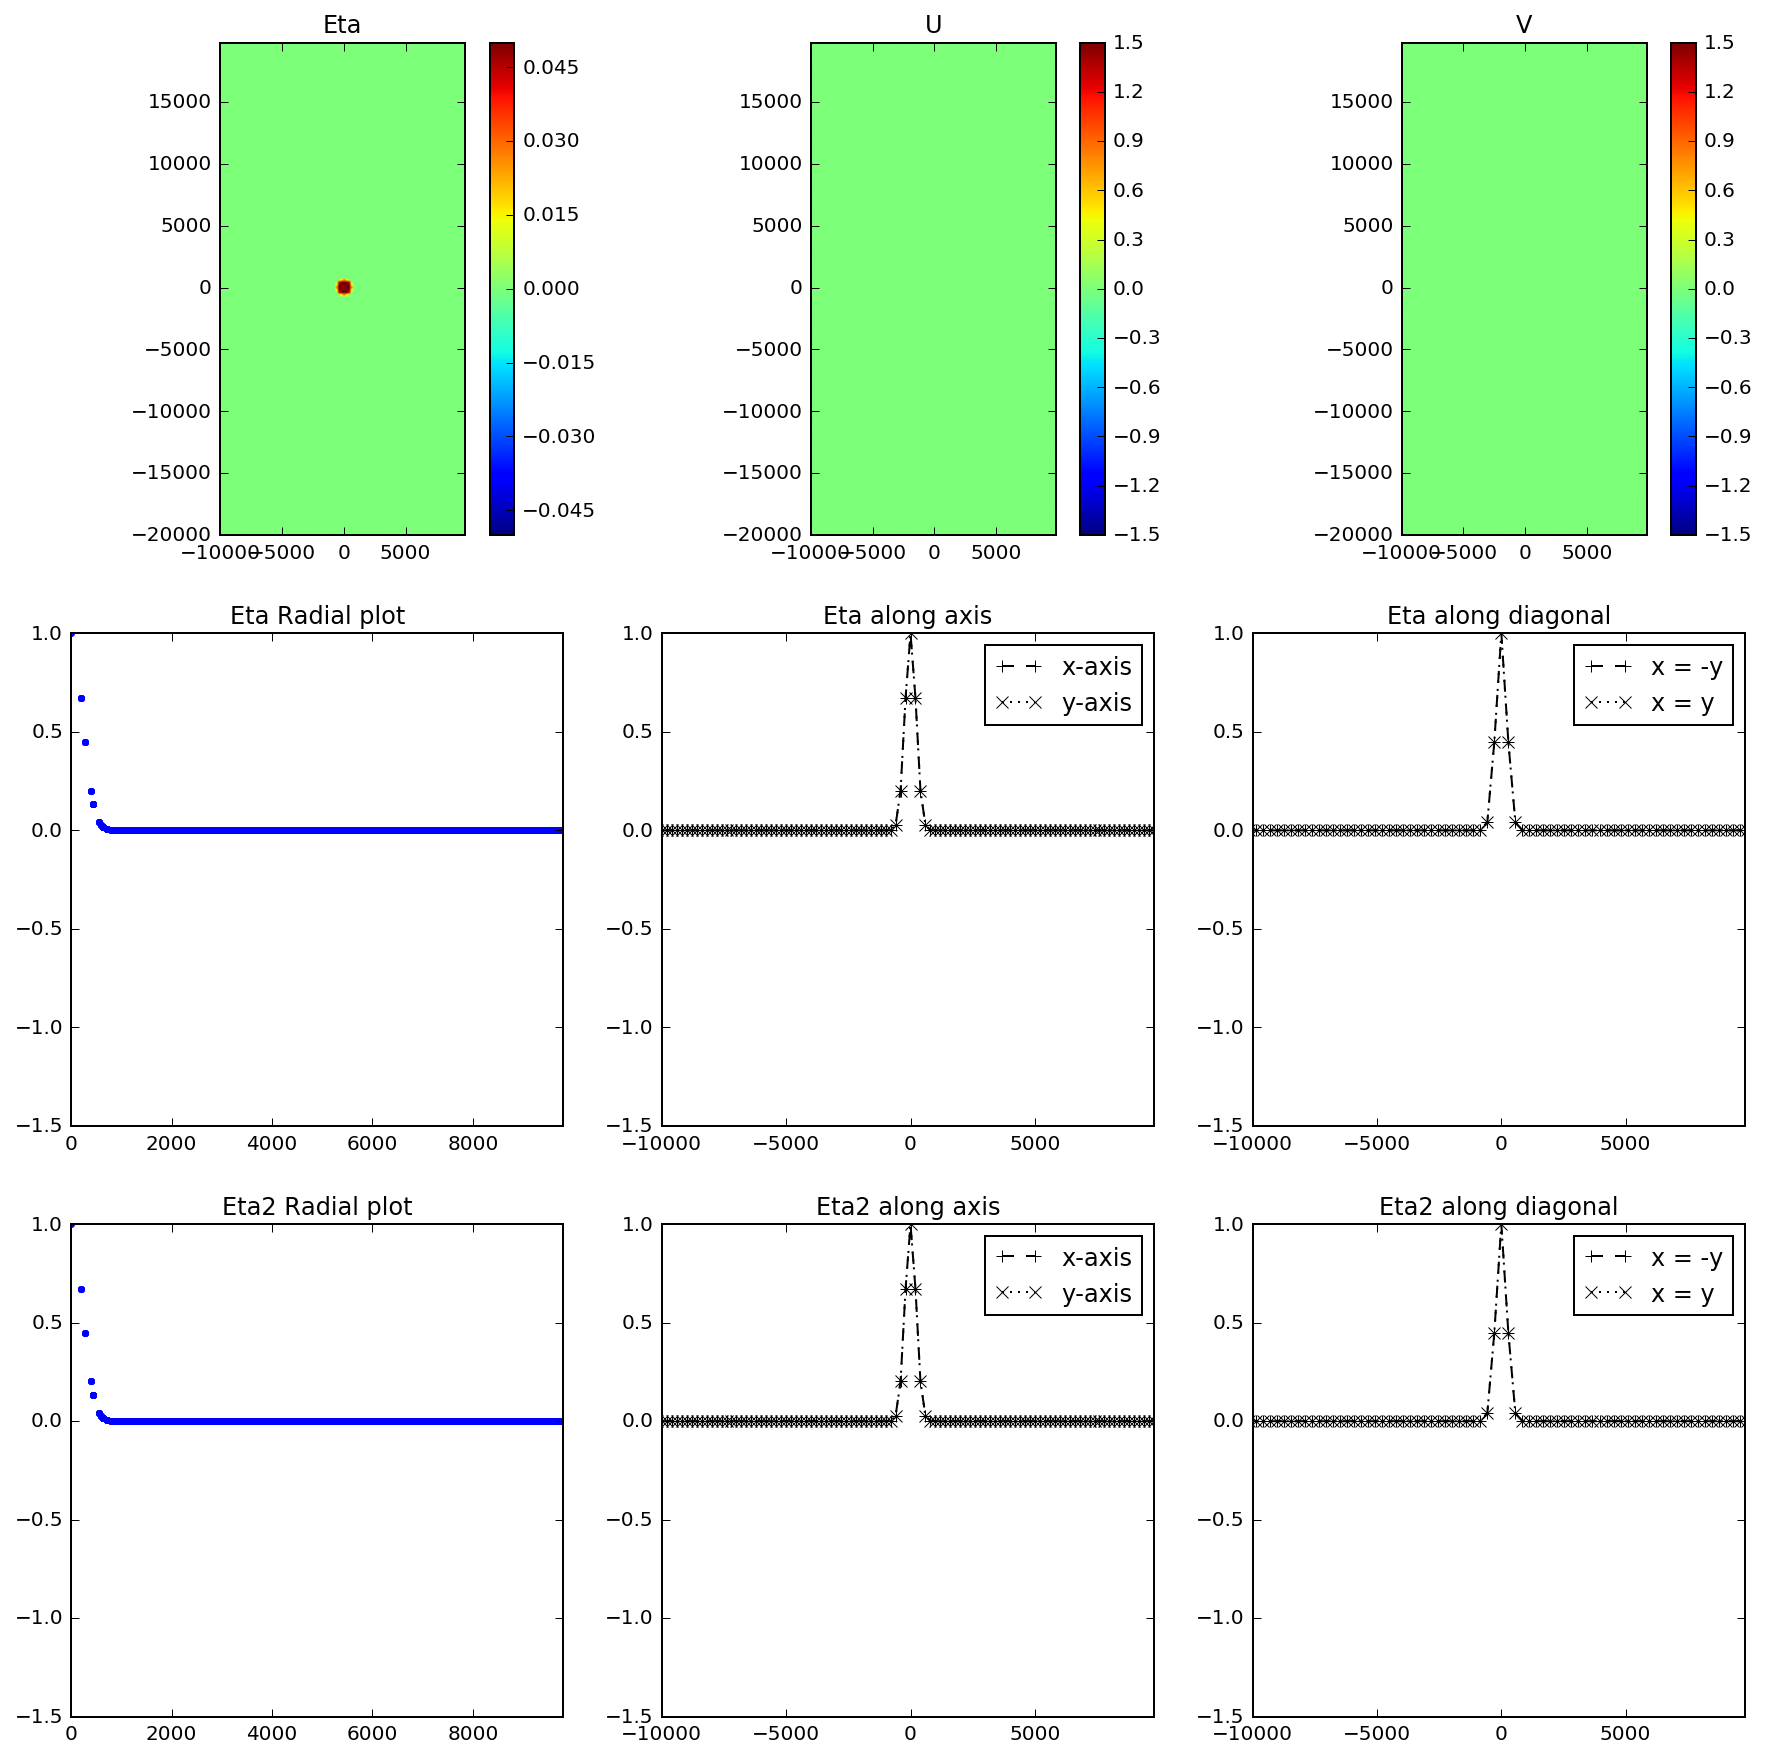

In [4]:
nx = 100
ny = 200

dx = 200.0
dy = 200.0

dt = 1
g = 9.81
f = 0.0

rho1 = 1025.0
rho2 = 1030.0

r1 = 0.001
r2 = 0.0 #0.002

A = 1

h1 = np.ones((ny+2, nx+2), dtype=np.float32, order='C') * 10;
eta1 = np.zeros((ny+2, nx+2), dtype=np.float32, order='C');
u1 = np.zeros((ny+2, nx+1), dtype=np.float32, order='C');
v1 = np.zeros((ny+1, nx+2), dtype=np.float32, order='C');

h2 = np.ones((ny+2, nx+2), dtype=np.float32, order='C') * 50;
eta2 = np.zeros((ny+2, nx+2), dtype=np.float32, order='C');
u2 = np.zeros((ny+2, nx+1), dtype=np.float32, order='C');
v2 = np.zeros((ny+1, nx+2), dtype=np.float32, order='C');

#Create bump in center of domain for testing
x_center = dx*nx/2.0
y_center = dy*ny/2.0
for j in range(-1, ny+1):
    for i in range(-1, nx+1):
        x = dx*i - x_center 
        y = dy*j - y_center
        size = 500.0*min(dx, dy)
        if (np.sqrt(x**2 + y**2) < size):
            ratio = h1[j+1, i+1] / (h1[j+1, i+1] + h2[j+1, i+1])
            eta1[j+1, i+1] =  np.exp(-(x**2/size+y**2/size))
            eta2[j+1, i+1] =  np.exp(-(x**2/size+y**2/size))
            #eta2[j+1, i+1] = np.exp(-(x**2/size+y**2/size))
            
            
#Initialize simulator
reload(CTCS2Layer)
sim = CTCS2Layer.CTCS2Layer(cl_ctx,\
                h1, eta1, u1, v1, \
                h2, eta2, u2, v2, \
                nx, ny, \
                dx, dy, dt, \
                g, f, r1, r2, A, \
                rho1, rho2)


#Calculate radius from center of bump for plotting
y_coords, x_coords = np.mgrid[0:ny*dy:dy, 0:nx*dx:dx]
x_coords = np.subtract(x_coords, x_center)
y_coords = np.subtract(y_coords, y_center)
radius = np.sqrt(np.multiply(x_coords, x_coords) + np.multiply(y_coords, y_coords))


fig = plt.figure()
reload(PlotHelper)
plotter = PlotHelper.PlotHelper(fig, x_coords, y_coords, radius, \
                                eta1[1:-1, 1:-1],\
                                u1[1:-1, :] + u2[1:-1, :], \
                                v1[:, 1:-1] + v2[:, 1:-1], \
                                eta2[1:-1, 1:-1], \
                                u2[1:-1, :], \
                                v2[:, 1:-1])


def animate(i, writer):
    if (i>0):
        t = sim.step(10.0)
    else:
        t = 0.0
    eta1, u1, v1, eta2, u2, v2 = sim.download()

    plotter.plot(eta1[1:-1, 1:-1],\
                 u1[1:-1, :] + u2[1:-1, :], \
                 v1[:, 1:-1] + v2[:, 1:-1], \
                 eta2[1:-1, 1:-1],\
                 u2[1:-1, :], \
                 v2[:, 1:-1])
    fig.suptitle("CTCS-2 layer Time = " + "{:04.0f}".format(t) + " s", fontsize=18)

    if (i%10 == 0):
        print "{:03.0f}".format(100*i / 50.0) + " % => t=" + str(t)
        fig.savefig("{:010.0f}_ctcs2l.png".format(t))
    
#anim = animation.FuncAnimation(fig, animate, range(50), interval=100)
#plt.close(anim._fig)
#anim

reload(DataOutput)
with DataOutput.CTCSNetCDFWriter("2LayerTest.nc", nx, ny, dx, dy, num_layers=2, ignore_ghostcells=True) as writer:
    for i in range(50):
        if (i>0):
            t = sim.step(10.0)
        else:
            t = 0.0
        eta1, u1, v1, eta2, u2, v2 = sim.download()

        print "i: " + str(i) + " t: " + str(t)
        writer.write(i, t, eta1, u1, v1, eta2, u2, v2)